# Introduction to the Alpine API 1 - Running workflows and examing the results.  
## Using the Alpine API Python wrapper to:
1. Initialize a session
1. Run a workflow
1. Download and analyze the results

### Resources:
1.  [API documentation](https://alpine.atlassian.net/wiki/display/V5/Alpine+API)
2.  [API Demo](https://alpine.atlassian.net/wiki/display/V5/Alpine+API+Demo)
3.  [Anaconda Python](https://store.continuum.io/cshop/anaconda/) - All-in-one Python distribution.
4.  [Jupyter](http://jupyter.org/) - aka iPython notebook.  Included with Anaconda Python.
5.  [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html) - Source of data used in this demo.

### To access list of API functions, add /api to your alpine host:port URL.  Example: 10.0.0.216:8080/api
(Add new documentation)
### Setup:

1.  Create a new workspace called "API Demos" on your Alpine installation.
1.  Upload the included workflow API_Demo_1.afm into the new workspace.
1.  Upload the included data set, (magic04.csv), to your data source.
1.  Open the workflow and configure the data set to point to the location of your dataset in HDFS.  The default setting uses Spark to fit the logistic regression model.  You can turn off Spark in the Logistic Regression operator dialogue menu.
1.  Run the workflow through the Alpine UI to make sure that everything is configured correctly.

### Let's set some values that we'll be using in the demo. Find the url of the open work flow. You can read the host, port and workflow id from the url. For example, if the url is  http://10.10.0.204:8080/#work_flows/320:

In [1]:
host = "10.10.0.204"
port = "8080"
workflow_id = "322"

### You'll also need your Alpine username and password:

In [2]:
username = "demoadmin"
password = "password"

### Let's do some setup by importing some libraries and starting an API session.

In [3]:
from IPython.display import Image
import json
from pprint import pprint

In [4]:
import api as AlpineAPI

In [5]:
session = AlpineAPI.Alpine(host, port, username, password)

2017-01-20 15:20:07,097 requests.packages.urllib3.connectionpool connectionpool[214] INFO: Starting new HTTP connection (1): 10.10.0.204


### Some of the API calls are going to be used many times in this demo.  To keep organized, and to reduce repeated code, I'll wrap these API calls in a function.  Here's one for logging in to Alpine.  First, we build the correct URL and body information to authenticate.  Getting a JSON object in response indicates a succesful login.  We will need to use the session_id later, so I'll return it from `login()` and save it.

In [6]:
session.get_login_status().get("response").get("user").get("id")

665

### Here's the *API Demo 1* workflow.  It's a basic classification workflow, using a test/train split to verify that our logistic regression model generalizes well to the test data.


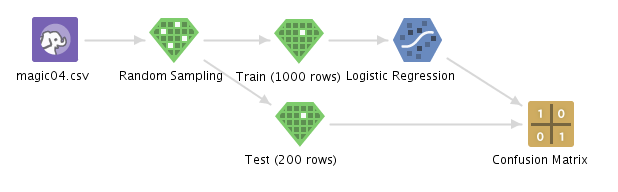

In [7]:
Image(filename='Images/Demo1.png')

### Let's run the workflow. We can use the .workfile.run_workflow() function. It wil construct the proper url for you, create a post request. A succesful post will return a process id unique to this run. We can use the id to query the workflow or download results.

In [8]:
process_id = session.workfile.run_workflow(workflow_id)
print(process_id)

03de5f7a-682a-44ef-823b-6ecd01084fe5


### Workflows can take a while to complete.  We can poll the status of the workflow using .workfile.query_workflow_status().  You can run this cell several times to see how the status changes as the workflow progresses. 

In [9]:
session.workfile.query_workflow_status(process_id)

'WORKING'

### We could continue to run the previous cell over and over to test if the workflow is complete, but we also have a convenience method to do this automatically. By default, it queries the workflow status every 10 seconds.

### Run the next cell while the workflow is still in progress.

In [10]:
session.workfile.wait_for_workflow_to_finish(process_id, verbose=True)

Workflow in progress for ~70 seconds.

'FINISHED'

### Now we can download the result.  `workflow_result` contains all the information that appears in the bottom window of the Alpine workflow editor, along with some logs and metadata.   To access that information we can convert it from a JSON string to a nested dict/list python object.  This can potentially be quite large.  Generally, we won't want to print it to screen, but go ahead and do it once if you are curious.


In [12]:
workflow_result = session.workfile.download_workflow_results(workflow_id, process_id)

pprint(workflow_result, depth=2)

{u'flowMetaInfo': {u'endTime': u'2017-01-20T15:21:27.123-0800',
                   u'executeUser': u'665',
                   u'noOfError': 0,
                   u'noOfNodesProcessed': 6,
                   u'processId': u'03de5f7a-682a-44ef-823b-6ecd01084fe5',
                   u'startTime': u'2017-01-20T15:20:13.799-0800',
                   u'status': u'SUCCESS',
                   u'workflowId': u'322',
                   u'workflowName': u'API_Demo_1'},
 u'logs': [{...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...},
           {...}],
 u'outputs': [{...}, {...}, {...}, {...}, {...}, {...}]}


###  The output  from each operator is stored in the list `result['outputs']`.  For instance, the name of the ith operator can be found at `result['outputs'][i]['out_title']`.

In [14]:
operator_list = workflow_result['outputs']
print("Number of operators in workflow = {}".format(len(operator_list)))
print("Name of the 3rd operator is '{}'".format(operator_list[3]['out_title']))

Number of operators in workflow = 6
Name of the 3rd operator is 'Test (200 rows)'


### We are interested in knowing the prediction accuracy of our trained logistic regression model on the test set.  In the workflow, this is calculated in the *Confusion Matrix* operator.  We can iterate over this list to find the operator that has the matching name.

In [15]:
# def find_operator(name, oper_list):
#     for oper in oper_list:
#         if oper['out_title'] == name:
#             return oper
#     return []

matching_name = 'Confusion Matrix'
output_operator = session.workfile.find_operator(matching_name, operator_list)
pprint(output_operator)

{u'isGenerateReport': True,
 u'out_id': 1484954487121.408,
 u'out_title': u'Confusion Matrix',
 u'visualData': [{u'isGenerateReport': True,
                  u'out_id': 1484954487119.8884,
                  u'out_title': u'Logistic Regression: Data',
                  u'visualData': {u'columnTypes': [u'cate',
                                                   u'cate',
                                                   u'cate',
                                                   u'cate'],
                                  u'columns': [u' ',
                                               u'Predicted (0)',
                                               u'Predicted (1)',
                                               u'Class Recall'],
                                  u'fixedNumberOfColumns': 0,
                                  u'items': [{u' ': u'Observed (0)',
                                              u'Class Recall': u'0.4559',
                                              u'Predict

### Each operator has a different data output format, but for a *Confusion Matrix* we can find the prediction accuracy on the test set like this.

In [16]:
acc = output_operator['visualData'][1]['visualData']['heatMapTable']['accuracy']
print("Accuracy = {0:.1f}%".format(acc*100))

Accuracy = 78.2%
